In [3]:
import numpy as np
from matplotlib import pyplot as plt
from scipy import interpolate
import cv2
from itertools import product
from pathlib import Path
import a3_utils
import math
from matplotlib.colors import hsv_to_rgb

# Exercise 1: Image derivatives

## a) Derive the equations used to compute first and second derivatives

Let $I_o$ be the original image and $G$ Gaussian filter.

$$ G(x, y) = g(x)g(y) $$
$$ I(x,y) = g(x)*g(y)*I_o(x,y) $$

$I$ is now the blured image. Taking into account the associative property of the convolution $\frac{d}{dx} (g ∗ f) = \left( \frac{d}{dx} g\right) ∗ f $, we get

$$ I_x = \frac{\partial}{\partial x} \left[  g(x) * g(y) * I_o\right] = \frac{d}{dx} g(x) * \left[ g(y) * I_o \right] $$
$$ I_y = \frac{\partial}{\partial y} \left[  g(x) * g(y) * I_o\right] = \frac{d}{dy} g(y) * \left[ g(x) * I_o \right] $$
$$ I_{xx} = \frac{\partial}{\partial x} \left[  g(x) * g(y) * I_x\right] = \frac{d}{dx} g(x) * \left[ g(y) * I_x \right] $$
$$ I_{yy} = \frac{\partial}{\partial y} \left[  g(x) * g(y) * I_y\right] = \frac{d}{dy} g(y) * \left[ g(x) * I_y \right] $$
$$ I_{xy} = \frac{\partial}{\partial y} \left[  g(x) * g(y) * I_x\right] = \frac{d}{dy} g(y) * \left[ g(x) * I_x \right] $$

## b) Implement a function that computes the derivative of a 1-D Gaussian kernel

In [4]:
def gauss(sigma, size):
    x = np.linspace(-3*sigma-.5, 3*sigma+.5, size)
    g = 1/(sigma*np.sqrt(2*np.pi))*np.exp(-(x**2)/(2*sigma**2))
    g /= g.sum()
    return g.reshape((-1, 1)), x

In [5]:
def gaussdx(sigma, size):
    x = np.linspace(-3*sigma-.5, 3*sigma+.5, size)
    g = 1/(sigma*np.sqrt(2*np.pi))*np.exp(-(x**2)/(2*sigma**2))*-2*x/(2*sigma**2)
    g /= np.abs(g).sum()
    return g.reshape((-1, 1)), x

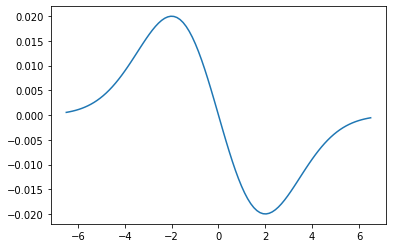

In [6]:
g, x = gaussdx(2, 100)
plt.plot(x, g)

## c) The properties of the filter can be analyzed by using an _impulse response function_

(<AxesSubplot:title={'center':'$D^T * G$'}>,
 <matplotlib.image.AxesImage at 0x2205059ad90>)

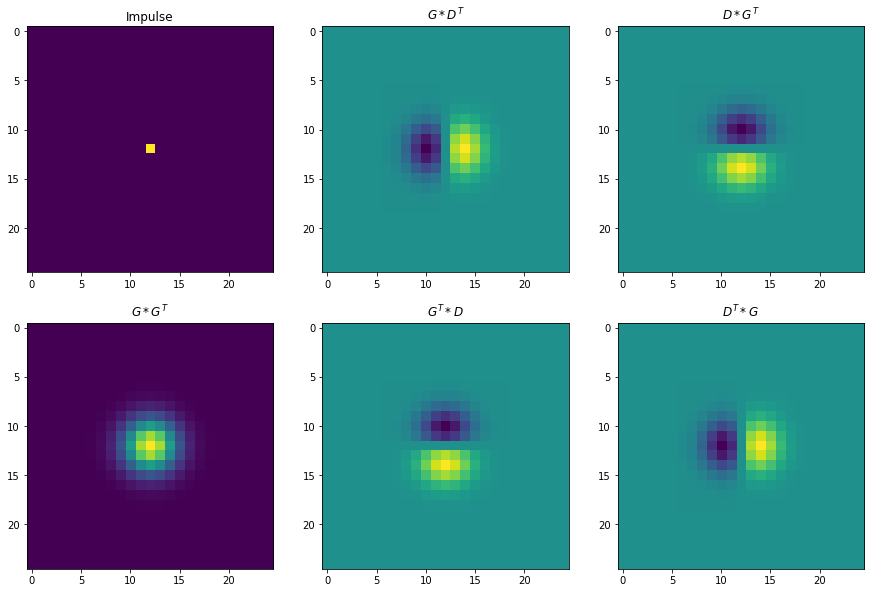

In [7]:
impulse = np.zeros((25,25))
impulse[12,12]=255

G, _ = gauss(2, 13)
D, _ = gaussdx(2, 13)

plt.figure(figsize=(15, 10))
plt.subplot(2, 3, 1, title="Impulse"), plt.imshow(impulse)
plt.subplot(2, 3, 2, title="$G * D^T$"), plt.imshow(cv2.filter2D(cv2.filter2D(impulse, -1, G), -1, D.T))
plt.subplot(2, 3, 3, title="$D * G^T$"), plt.imshow(cv2.filter2D(cv2.filter2D(impulse, -1, D), -1, G.T))
plt.subplot(2, 3, 4, title="$G * G^T$"), plt.imshow(cv2.filter2D(cv2.filter2D(impulse, -1, G), -1, G.T))
plt.subplot(2, 3, 5, title="$G^T * D$"), plt.imshow(cv2.filter2D(cv2.filter2D(impulse, -1, G.T), -1, D))
plt.subplot(2, 3, 6, title="$D^T * G$"), plt.imshow(cv2.filter2D(cv2.filter2D(impulse, -1, D.T), -1, G))

## d) Gradient

(<AxesSubplot:title={'center':'$I_{dir}$'}>,
 <matplotlib.image.AxesImage at 0x22052b31df0>)

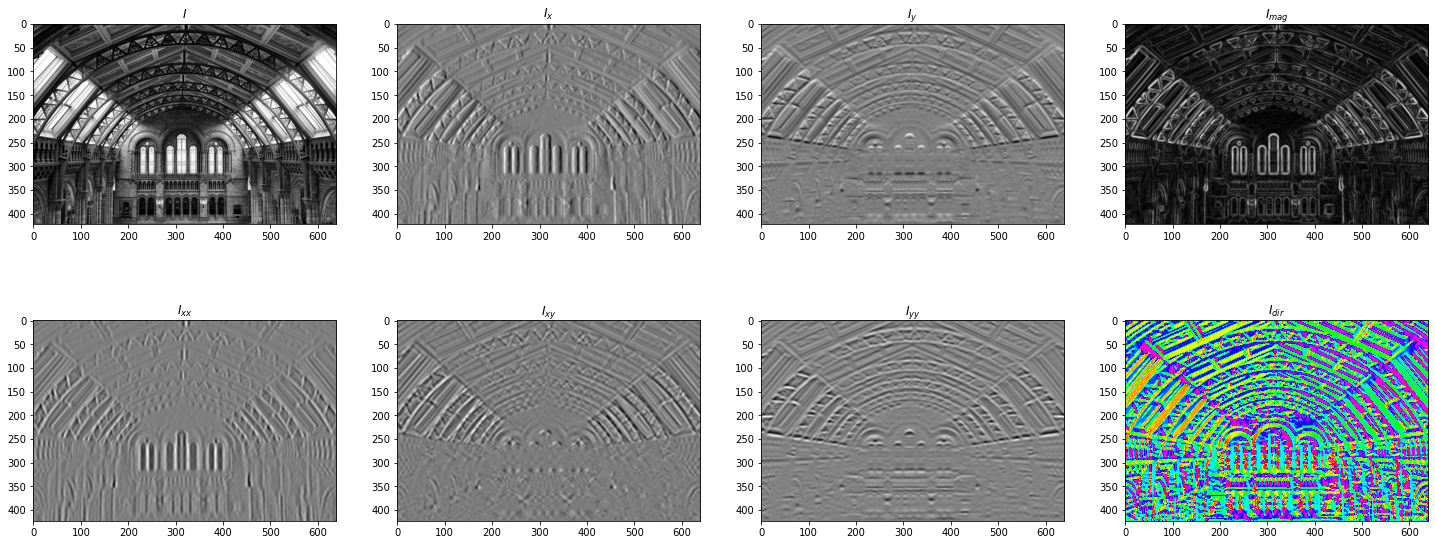

In [8]:

museum = cv2.cvtColor(cv2.imread('images/museum.jpg'), cv2.COLOR_BGR2RGB)
museum_gray = cv2.cvtColor(museum, cv2.COLOR_RGB2GRAY).astype('float64')

museum_x = cv2.filter2D(cv2.filter2D(museum_gray, -1, -D.T), -1, G)
museum_y = cv2.filter2D(cv2.filter2D(museum_gray, -1, G.T), -1, -D)
museum_xx = cv2.filter2D(cv2.filter2D(museum_x, -1, -D.T), -1, G)
museum_yy = cv2.filter2D(cv2.filter2D(museum_y, -1, G.T), -1, -D)
museum_xy = cv2.filter2D(cv2.filter2D(museum_x, -1, G.T), -1, -D)

museum_mag = np.sqrt(museum_x**2 + museum_y**2)
museum_dir = np.arctan2(museum_y, museum_x)


plt.figure(figsize=(25, 10))
plt.subplot(2, 4, 1, title="$I$"), plt.imshow(museum_gray, cmap='gray')
plt.subplot(2, 4, 2, title="$I_x$"), plt.imshow(museum_x, cmap='gray')
plt.subplot(2, 4, 3, title="$I_y$"), plt.imshow(museum_y, cmap='gray')
plt.subplot(2, 4, 4, title="$I_{mag}$"), plt.imshow(museum_mag, cmap='gray')
plt.subplot(2, 4, 5, title="$I_{xx}$"), plt.imshow(museum_xx, cmap='gray')
plt.subplot(2, 4, 6, title="$I_{xy}$"), plt.imshow(museum_xy, cmap='gray')
plt.subplot(2, 4, 7, title="$I_{yy}$"), plt.imshow(museum_yy, cmap='gray')
plt.subplot(2, 4, 8, title="$I_{dir}$"), plt.imshow(museum_dir, cmap='hsv', vmin=-np.pi, vmax=np.pi)

In [9]:
def show_gradient(I_mag, I_dir):
    hsv = np.stack([(I_dir+np.pi)/(2*np.pi), np.ones_like(I_mag), I_mag/I_mag.max()], axis=-1)
    rgb = hsv_to_rgb(hsv)
    plt.title("Hue = direction, Saturation = 1, Value = magnitude")
    plt.imshow(rgb)

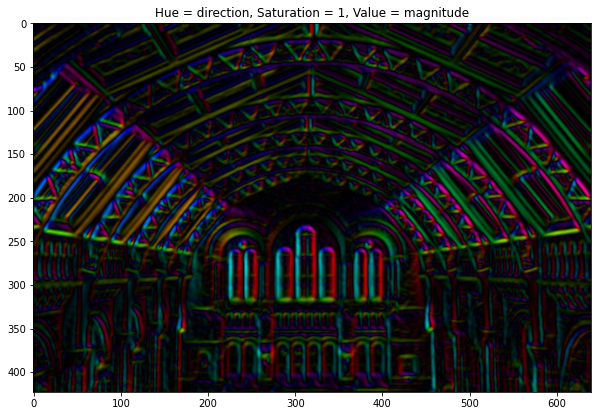

In [10]:
plt.figure(figsize=(10,10))
show_gradient(museum_mag, museum_dir)

# Exercise 2: Edges in images

## a) Find edges

In [11]:
def findedges(I, sigma, theta):
    G, _ = gauss(sigma, 2*math.ceil(sigma*3)+1)
    D, _ = gaussdx(sigma, 2*math.ceil(sigma*3)+1)
    I_x= cv2.filter2D(cv2.filter2D(museum_gray, -1, -D.T), -1, G)
    I_y = cv2.filter2D(cv2.filter2D(museum_gray, -1, G.T), -1, -D)
    I_mag =  np.sqrt(I_x**2 + I_y**2)
    I_e = np.where(I_mag > theta, 1, 0)
    return I_e

In [12]:
def gradient(I, sigma):
    G, _ = gauss(sigma, 2*math.ceil(sigma*3)+1)
    D, _ = gaussdx(sigma, 2*math.ceil(sigma*3)+1)
    I_x = cv2.filter2D(cv2.filter2D(I, -1, -D.T), -1, G)
    I_y = cv2.filter2D(cv2.filter2D(I, -1, G.T), -1, -D)
    I_mag =  np.sqrt(I_x**2 + I_y**2)
    I_dir = np.arctan2(I_y, I_x)
    
    return I_mag.astype('float64'), I_dir.astype('float64')

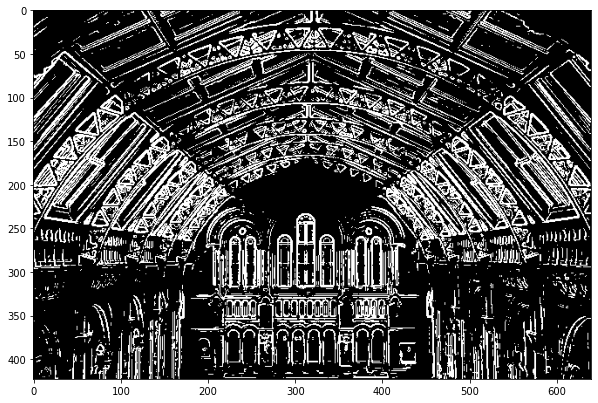

In [13]:
museum_e = findedges(museum, 1, 25)

plt.figure(figsize=(10,10))
plt.imshow(museum_e, cmap='gray')

## b) Nonmaxima suppression

In [220]:
def nonmaxima_suppression_gradient(img_mag, img_dir):
    res = img_mag.copy()
    for y in range(1, img_mag.shape[0]-1):
        for x in range(1, img_mag.shape[1]-1):
            v = img_mag[y,x]
            fi = (img_dir[y,x] + np.pi/8) % np.pi
            if( 0 <= fi and fi < np.pi/4): # --
                if v < img_mag[y, x-1] or v < img_mag[y, x+1]: res[y,x] = 0
            if( np.pi/4 <= fi and fi < np.pi/2): # /
                if v < img_mag[y-1, x-1] or v < img_mag[y+1, x+1]: res[y,x] = 0
            if( np.pi/2 <= fi and fi < 3*np.pi/4): # |
                if v < img_mag[y-1, x] or v < img_mag[y+1, x]: res[y,x] = 0
            if( 3*np.pi/4 <= fi and fi < np.pi): # \
                if v < img_mag[y+1, x-1] or v < img_mag[y-1, x+1]: res[y,x] = 0
                
    return res
    

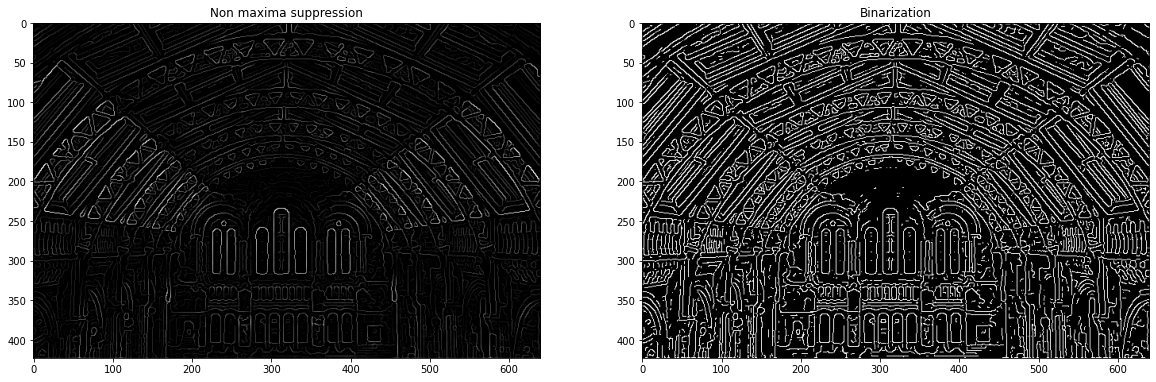

In [224]:
museum_e_s = nonmaxima_suppression_gradient(museum_mag, museum_dir)
museum_e_s_b = np.where(museum_e_s > 10, 1, 0)

plt.figure(figsize=(20,10))
plt.subplot(1,2,1)
plt.title("Non maxima suppression")
plt.imshow(museum_e_s, cmap='gray')
plt.subplot(1,2,2)
plt.title("Binarization")
plt.imshow(museum_e_s_b, cmap='gray')

## c) Edge tracking by hysteresis

(<AxesSubplot:title={'center':'High threshold'}>,
 Text(0.5, 1.0, 'High threshold'),
 <matplotlib.image.AxesImage at 0x22063c3b730>)

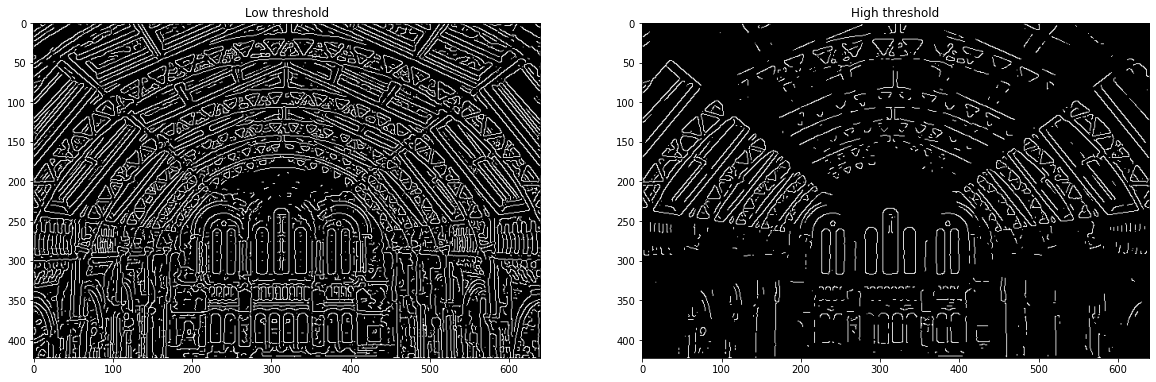

In [230]:
museum_e_s = nonmaxima_suppression_gradient(museum_mag, museum_dir)
museum_low = np.where(museum_e_s > 8, 1, 0)
museum_high = np.where(museum_e_s > 30, 1, 0)

plt.figure(figsize=(20,10))
plt.subplot(1, 2, 1), plt.title("Low threshold"), plt.imshow(museum_low, cmap='gray')
plt.subplot(1, 2, 2), plt.title("High threshold"), plt.imshow(museum_high, cmap='gray')

In [239]:
n, labels, stats, centroids = cv2.connectedComponentsWithStats(museum_low.astype('uint8'), connectivity=8)

result = np.zeros_like(museum_low)

for i in range(1, n):
    if np.max(museum_high[labels == i]) > 0:
        result[labels == i] = 1

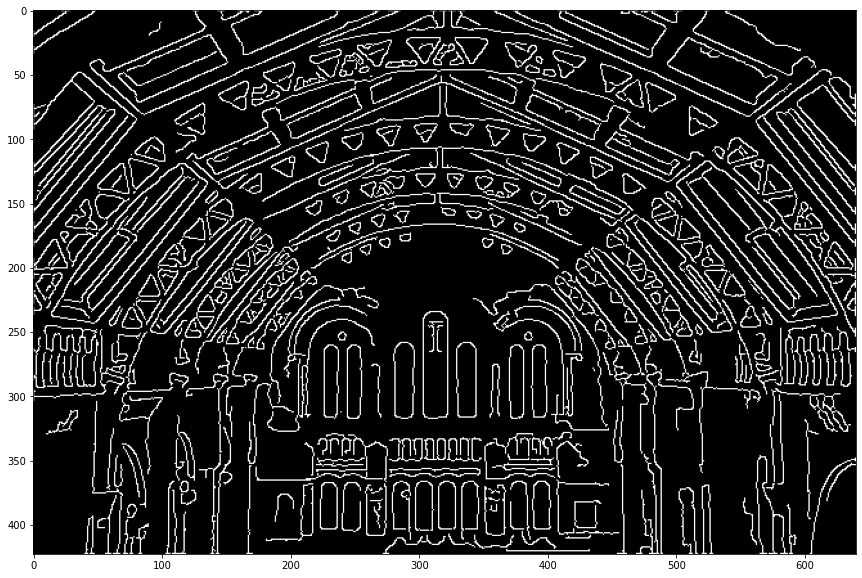

In [241]:
plt.figure(figsize=(20,10))
plt.imshow(result, cmap='gray')

# Exercise 3: Detecting lines

## a) Create an array with a single nonzero point

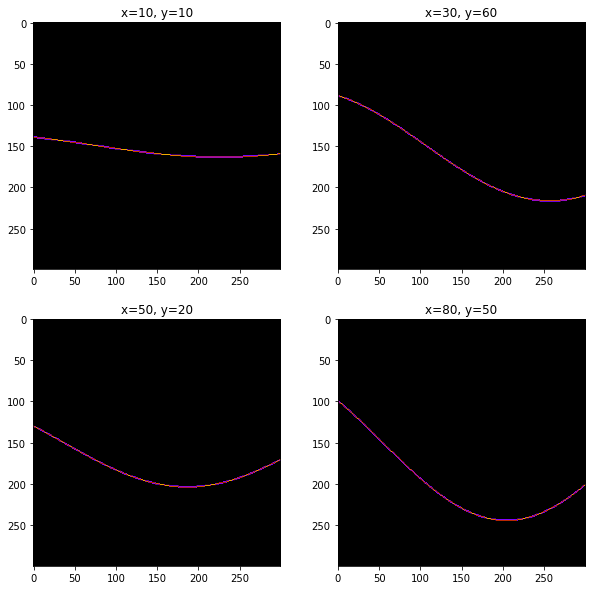

In [15]:
R = 300

points = [(10, 10), (30, 60), (50, 20), (80, 50)]

fig = plt.figure(figsize=(10, 10))
k = 1
for x, y in points:
    acc = np.zeros((300, 300))
    for i in range(R):
        fi = i/R * np.pi - np.pi/2 # from -PI to PI
        #fi = i/360 * np.pi
        # x cos(fi) + y sin(fi) = t
        ro = x * np.cos(fi) + y * np.sin(fi)
        j = round(ro + R/2)
        if j < 0 or j >= R: continue
    
        acc[j][i]+=1

    ax = fig.add_subplot(2, 2, k, title=f"x={x}, y={y}")
    ax.imshow(acc, cmap='gnuplot')
    
    k += 1
    

## b) Implement the function `hough_find_lines`

In [16]:
def hough_find_lines_old(img, theta_bins, rho_bins):
    acc = np.zeros((rho_bins, theta_bins))
    
    D = np.sqrt(img.shape[0]**2 + img.shape[1]**2)
    
    for y in range(img.shape[0]):
        for x in range(img.shape[1]):
            if img[x][y] >= 1:
                for i in range(theta_bins):
                    theta = i/theta_bins * np.pi - np.pi/2 # from -PI/2 to PI/2
                    
                    rho = x * np.cos(theta) + y * np.sin(theta)
                    
                    j = round((rho + D) / (2*D) * rho_bins)
                    
                    if j < 0 or j >= rho_bins: continue
                    
                    acc[j][i] += 1
    
    return acc

In [17]:
def hough_find_lines(img, theta_bins, rho_bins):
    acc = np.zeros((rho_bins, theta_bins), dtype='int32')
    
    D = np.sqrt(img.shape[0]**2 + img.shape[1]**2)
    
    thetas = np.linspace(-np.pi/2, np.pi/2, theta_bins)
    i_s = np.arange(theta_bins)
    
    for (y,x), v in np.ndenumerate(img):
        if v < 1: continue
        
        rhos = x * np.cos(thetas) + y * np.sin(thetas)
        j_s = np.round((rhos + D) / (2*D) * rho_bins).astype('int32')
        
        acc[j_s, i_s] += 1
    
    return acc

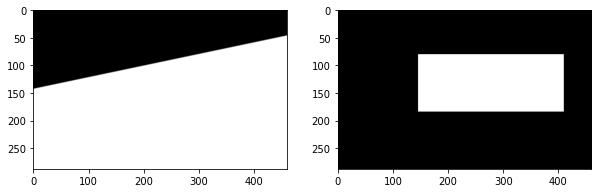

In [18]:
oneline = cv2.cvtColor(cv2.imread('images/oneline.png'), cv2.COLOR_BGR2GRAY)
rectangle = cv2.cvtColor(cv2.imread('images/rectangle.png'), cv2.COLOR_BGR2GRAY)

plt.figure(figsize=(10, 10))
plt.subplot(1, 2, 1)
plt.imshow(oneline, cmap='gray')
plt.subplot(1, 2, 2)
plt.imshow(rectangle, cmap='gray')

In [19]:
theta_bins = 600
rho_bins = 600

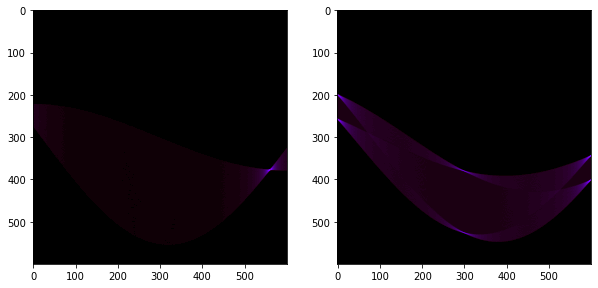

In [20]:
rectangle_e = cv2.Canny(image=rectangle, threshold1=100, threshold2=200)
oneline_e = cv2.Canny(image=oneline, threshold1=100, threshold2=200)


oneline_acc = hough_find_lines(oneline_e, theta_bins, rho_bins)
rectangle_acc = hough_find_lines(rectangle_e, theta_bins, rho_bins)
plt.figure(figsize=(10, 10))
plt.subplot(1, 2, 1)
plt.imshow(oneline_acc, cmap='gnuplot')
plt.subplot(1, 2, 2)
plt.imshow(rectangle_acc, cmap='gnuplot')

## Implement a function named `nonmaxima_suppression_box`

In [21]:
def nonmaxima_suppression_box(img):
    img_suppressed = img.copy()
    for (i, j), pixel_val in np.ndenumerate(img):
        neighbors = product(
            [(i-1)%img.shape[0], i, (i+1)%img.shape[0]], # % img.shape to wrap around image
            [(j-1)%img.shape[1], j, (j+1)%img.shape[1]]
        )
        for u, v in neighbors:
            if pixel_val < img[u, v]:
                img_suppressed[i, j] = 0 # not a maximum, suppress!
    return img_suppressed

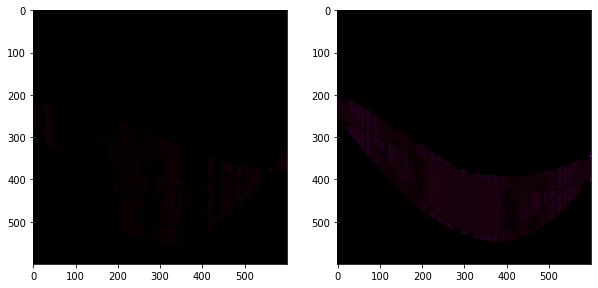

In [22]:
oneline_suppressed = nonmaxima_suppression_box(oneline_acc)
rectangle_suppressed = nonmaxima_suppression_box(rectangle_acc)

plt.figure(figsize=(10, 10))
plt.subplot(1, 2, 1)
plt.imshow(oneline_suppressed, cmap='gnuplot')
plt.subplot(1, 2, 2)
plt.imshow(rectangle_suppressed, cmap='gnuplot')

## d) Extract the parameter pairs $(\rho, \vartheta)$

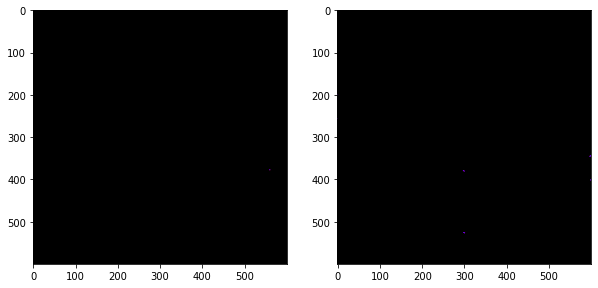

In [23]:
threshold = 100

oneline_bin = np.where(oneline_suppressed < threshold, 0, 1)
rectangle_bin = np.where(rectangle_suppressed < threshold, 0, 1)

plt.figure(figsize=(10, 10))
plt.subplot(1, 2, 1)
plt.imshow(oneline_bin, cmap='gnuplot')
plt.subplot(1, 2, 2)
plt.imshow(rectangle_bin, cmap='gnuplot')

In [24]:
def draw_line(rho, theta, max_rho):
	a = np.cos(theta)
	b = np.sin(theta)

	x0 = a*rho
	y0 = b*rho

	x1 = int(x0 + max_rho*(-b))
	y1 = int(y0 + max_rho*(a))
	x2 = int(x0 - max_rho*(-b))
	y2 = int(y0 - max_rho*(a))

	plt.plot((x1,x2),(y1,y2),'r')

In [25]:
def draw_image_with_lines(img, acc_bin):
    D = np.sqrt(img.shape[0]**2 + img.shape[1]**2)
    
    for j, i in np.argwhere(acc_bin):
        rho = (2*D*j)/rho_bins - D
        theta = i/theta_bins * np.pi - np.pi/2
        draw_line(rho, theta, img.shape[1])
    plt.imshow(img, cmap='gray')

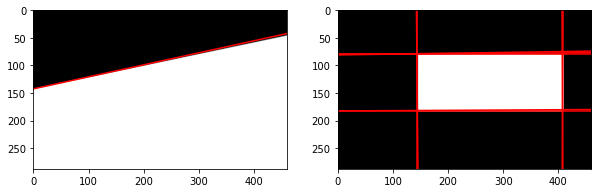

In [26]:
plt.figure(figsize=(10, 10))
plt.subplot(1, 2, 1)
draw_image_with_lines(oneline, oneline_bin)
plt.subplot(1, 2, 2)
draw_image_with_lines(rectangle, rectangle_bin)

## e) Find lines in `bricks.jpg` and `pier.jpg`

In [193]:

def find_and_draw_lines(img_color):
    plt.figure(figsize=(25,15))
    
    img_gray = cv2.cvtColor(img_color, cv2.COLOR_RGB2GRAY)
    plt.subplot(1, 5, 1), plt.imshow(img_color)
    
    img_edges = cv2.Canny(img_gray, 150, 250)
    plt.subplot(1, 5, 2), plt.imshow(img_edges, cmap='gray')
    
    img_acc = hough_find_lines(img_edges, theta_bins, rho_bins)
    plt.subplot(1, 5, 3), plt.imshow(img_acc, cmap='gnuplot')
    
    img_acc_s = nonmaxima_suppression_box(img_acc)
    plt.subplot(1, 5, 4), plt.imshow(img_acc_s, cmap='gnuplot')
    
    D = np.sqrt(img_color.shape[0]**2 + img_color.shape[1]**2)
    
    N = 10
    
    plt.subplot(1, 5, 5)
    for j, i in zip(*np.unravel_index(np.argsort(img_acc_s, axis=None)[-N:], img_acc_s.shape)):
        rho = (2*D*j)/rho_bins - D
        theta = i/theta_bins * np.pi - np.pi/2
        draw_line(rho, theta, img_color.shape[1])
    plt.imshow(img_color)
    

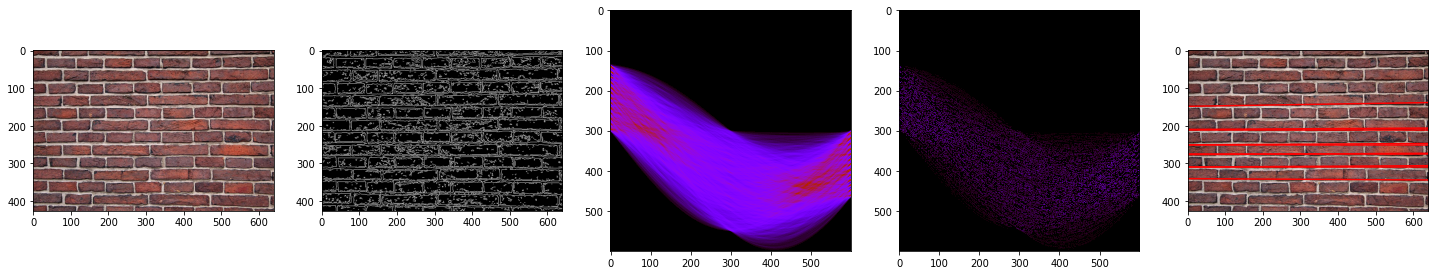

In [28]:
bricks = cv2.cvtColor(cv2.imread('images/bricks.jpg'), cv2.COLOR_BGR2RGB)
find_and_draw_lines(bricks)


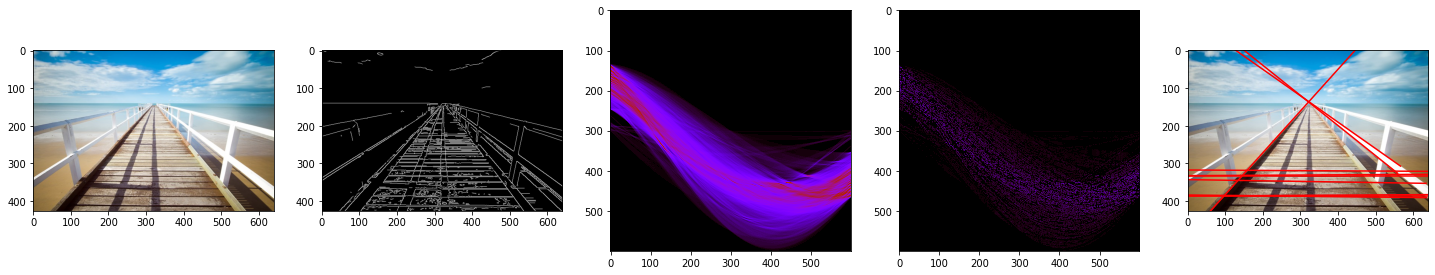

In [29]:
pier = cv2.cvtColor(cv2.imread('images/pier.jpg'), cv2.COLOR_BGR2RGB)
find_and_draw_lines(pier)

## f) Hough transform with gradients

In [30]:
def hough_find_lines_dir(img_mag, img_dir, theta_bins, rho_bins):
    img_bin = np.where(img_mag > 20, 1, 0)
    acc = np.zeros((rho_bins, theta_bins), dtype='int32')
    
    D = np.sqrt(img_mag.shape[0]**2 + img_mag.shape[1]**2)
    
    for (x,y), v in np.ndenumerate(img_bin): 
        if v < 1: continue

        theta = (img_dir[x,y] + np.pi/2) % np.pi - np.pi/2
        rhos = x * np.sin(theta) + y * np.cos(theta)
        j = np.round((rhos + D) / (2*D) * (rho_bins)).astype('int32')
        i = np.round((0.5 + (theta / np.pi)) * (theta_bins-1)).astype('int32')

        if j < 0 or j >= rho_bins: continue

        acc[j, i] += 1
    return acc

In [31]:
def find_and_draw_lines_dir(img_color):
    img_gray = cv2.cvtColor(img_color, cv2.COLOR_RGB2GRAY)
    img_mag, img_dir = gradient(img_gray.astype('float64'), 0.5)
    img_bin = np.where(img_mag > 20, 1, 0)
    img_acc = hough_find_lines_dir(img_mag, img_dir, theta_bins, rho_bins)
    img_acc_s = nonmaxima_suppression_box(img_acc)
    
    plt.figure(figsize=(25, 15))
    
    plt.subplot(1, 5, 1), plt.imshow(img_color)
    plt.subplot(1, 5, 2), show_gradient(img_bin, img_dir)
    plt.subplot(1, 5, 3), plt.imshow(img_acc, cmap='gnuplot')
    plt.subplot(1, 5, 4), plt.imshow(img_acc_s, cmap='gnuplot')
    
    D = np.sqrt(img_color.shape[0]**2 + img_color.shape[1]**2)
    N = 20
    plt.subplot(1, 5, 5)
    for j, i in zip(*np.unravel_index(np.argsort(img_acc_s, axis=None)[-N:], img_acc_s.shape)):
        rho = (2*D*j)/rho_bins - D
        theta = i/theta_bins * np.pi - np.pi/2
        draw_line(rho, theta, img_color.shape[1]*2)
    plt.imshow(img_color)


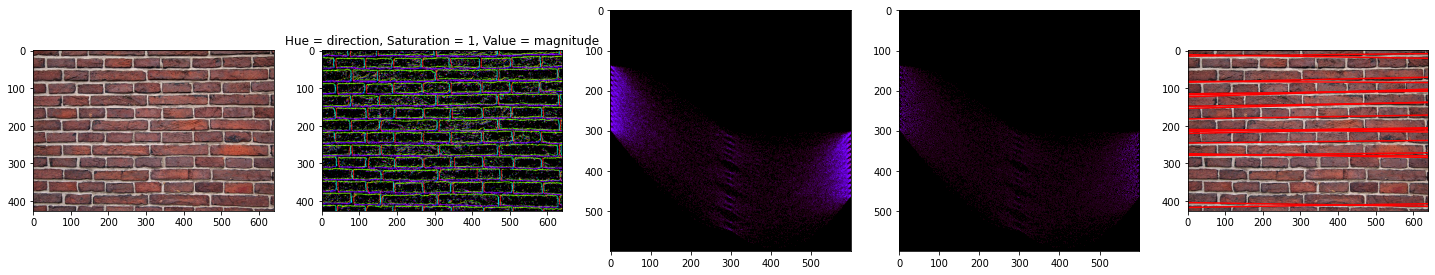

In [32]:
find_and_draw_lines_dir(bricks)

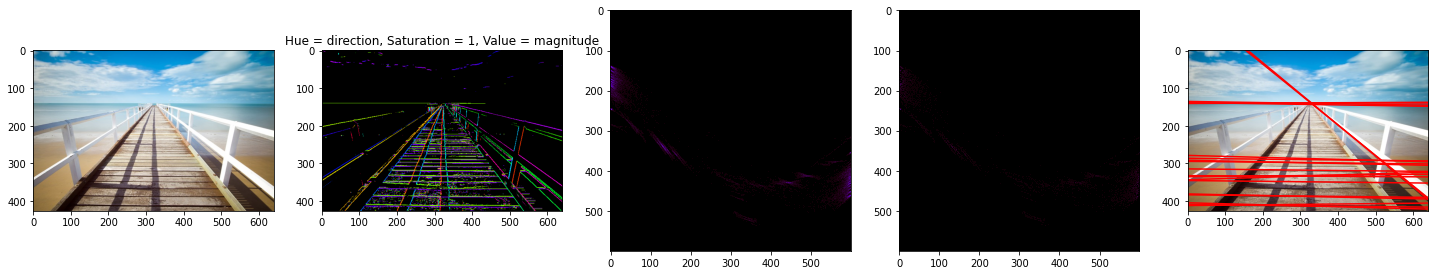

In [33]:
find_and_draw_lines_dir(pier)

## g) Implement a Hough transform that detects circles

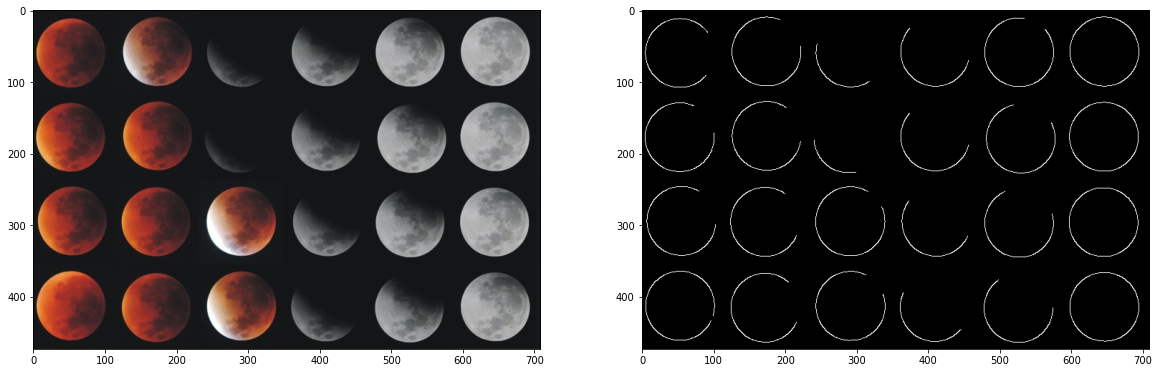

In [117]:
eclipse = cv2.cvtColor(cv2.imread('images/eclipse.jpg'), cv2.COLOR_BGR2RGB)
eclipse_gray = cv2.cvtColor(eclipse, cv2.COLOR_RGB2GRAY)
eclipse_edges = cv2.Canny(eclipse_gray, 100, 255)
plt.figure(figsize=(20,10))
plt.subplot(1, 2, 1)
plt.imshow(eclipse)
plt.subplot(1, 2, 2)
plt.imshow(eclipse_edges, cmap='gray')

$$ (x - a)^2 + (y - b)^2 = r^2 $$

$$ b = \pm \sqrt{r^2 - (x-a)^2} + y$$

In [35]:
def hough_find_circles_old(img, r):
    img_bin = cv2.Canny(img, 150, 150)
    acc = np.zeros_like(img, dtype='int32')
    
    a = np.arange(img.shape[1])
    for (y,x), v in np.ndenumerate(img):
        if v < 1: continue
        
        b = (-np.sqrt(r**2 - (-a+x)**2) + y).astype(np.int)
        
        b = b[(b <= 0) & (acc.shape[1] < b)] # remove indices out of bounds
        
        acc[b, a] += 1
    
    return acc

In [107]:
def hough_find_circles(img, r):
    acc = np.zeros_like(img, dtype='int32')
    
    for (y,x), v in np.ndenumerate(img):
        if v < 1: continue
        for a in range(acc.shape[1]):
            d = r**2 - (x-a)**2
            if d < 0: continue
            b1 = int(+ np.sqrt(d) + y)
            b2 = int(- np.sqrt(d) + y)
            
            if (0 <= b1) and (b1 < acc.shape[0]):            
                acc[b1, a] += 1
            if (0 <= b2) and (b2 < acc.shape[0]):            
                acc[b2, a] += 1
    return acc

In [135]:
acc = hough_find_circles(eclipse_edges, 48)
acc_s = nonmaxima_suppression_box(acc)

In [140]:
acc_b = np.where(acc_s > 50, 1, 0)

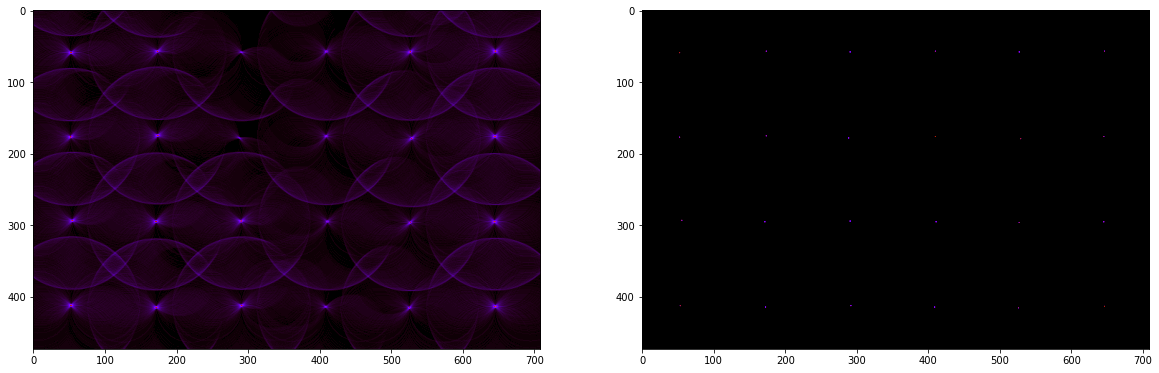

In [141]:
plt.figure(figsize=(20, 10))
plt.subplot(1, 2, 1)
plt.imshow(acc, cmap='gnuplot')
plt.subplot(1, 2, 2)
plt.imshow(acc_b, cmap='gnuplot')

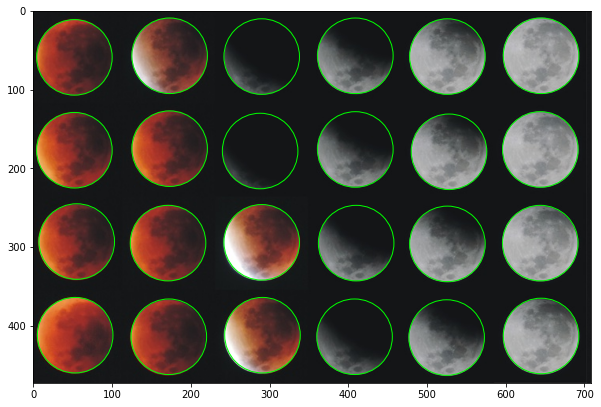

In [146]:
figure, ax = plt.subplots(figsize=(10, 10))
for (y,x), v in np.ndenumerate(acc_b):
    if v < 1: continue
    
    c = plt.Circle( (x, y ), 48 , fill = False, color="lime")
    ax.set_aspect(1)
    ax.add_artist(c)
plt.imshow(eclipse)

To determine maximum line length we have to find line intersection between $x \cos \vartheta + y \sin \vartheta = \rho$ and $y=0$, $y=h$, $x=0$ and $x=w$

$$ y = 0 \implies x\cos \vartheta = \rho \implies x = \frac{\rho}{\cos\vartheta}$$
$$ y = h \implies x\cos \vartheta + w\sin\vartheta = \rho \implies x = \frac{\rho - h\sin\vartheta}{\cos\vartheta}$$
$$ x = 0 \implies y\sin\vartheta = \rho \implies y = \frac{\rho}{\sin\vartheta}$$
$$ x = w \implies w\cos \vartheta + y\sin\vartheta = \rho \implies x = \frac{\rho - w\cos\vartheta}{\sin\vartheta}$$

In [185]:
def get_weight(rho, theta, w, h):
    P = []
    
    x = rho/np.cos(theta)
    if 0 <= x and x < w: P.append((x, 0))
    x = (rho - h*np.sin(theta))/np.cos(theta)
    if 0 <= x and x < w: P.append((x, h))
    y = rho/np.sin(theta)
    if 0 <= y and y < h: P.append((0, y))
    y = (rho - w*np.cos(theta))/np.sin(theta)
    if 0 <= y and y < h: P.append((w, y))
    
    if len(P) != 2: return 0
    length = np.sqrt((P[0][0] - P[1][0])**2 + (P[0][1] - P[1][1])**2)
    if length == 0: return 0
    
    return 1/length
    

In [189]:
def hough_find_lines_weighted(img, theta_bins, rho_bins):
    acc = np.zeros((rho_bins, theta_bins), dtype=np.float64)
    
    D = np.sqrt(img.shape[0]**2 + img.shape[1]**2)
    
    for y in range(img.shape[0]):
        for x in range(img.shape[1]):
            if img[y, x] >= 1:
                for i in range(theta_bins):
                    theta = i/theta_bins * np.pi - np.pi/2 # from -PI/2 to PI/2
                    
                    rho = x * np.cos(theta) + y * np.sin(theta)
                    
                    j = round((rho + D) / (2*D) * rho_bins)
                    
                    if j < 0 or j >= rho_bins: continue
                    
                    acc[j][i] += get_weight(rho, theta, img.shape[1], img.shape[0])
    
    return acc

In [190]:
def find_and_draw_lines_weighted(img_color):
    plt.figure(figsize=(25,15))
    
    img_gray = cv2.cvtColor(img_color, cv2.COLOR_RGB2GRAY)
    plt.subplot(1, 5, 1), plt.imshow(img_color)
    
    img_edges = cv2.Canny(img_gray, 150, 250)
    plt.subplot(1, 5, 2), plt.imshow(img_edges, cmap='gray')
    
    img_acc = hough_find_lines_weighted(img_edges, theta_bins, rho_bins)
    plt.subplot(1, 5, 3), plt.imshow(img_acc, cmap='gnuplot')
    
    img_acc_s = nonmaxima_suppression_box(img_acc)
    plt.subplot(1, 5, 4), plt.imshow(img_acc_s, cmap='gnuplot')
    
    D = np.sqrt(img_color.shape[0]**2 + img_color.shape[1]**2)
    
    N = 10
    
    plt.subplot(1, 5, 5)
    for j, i in zip(*np.unravel_index(np.argsort(img_acc_s, axis=None)[-N:], img_acc_s.shape)):
        rho = (2*D*j)/rho_bins - D
        theta = i/theta_bins * np.pi - np.pi/2
        draw_line(rho, theta, img_color.shape[1])
    plt.imshow(img_color)

<ipython-input-185-27a72abc01be>:8: RuntimeWarning: divide by zero encountered in double_scalars
  y = rho/np.sin(theta)
<ipython-input-185-27a72abc01be>:10: RuntimeWarning: divide by zero encountered in double_scalars
  y = (rho - w*np.cos(theta))/np.sin(theta)
<ipython-input-185-27a72abc01be>:8: RuntimeWarning: invalid value encountered in double_scalars
  y = rho/np.sin(theta)


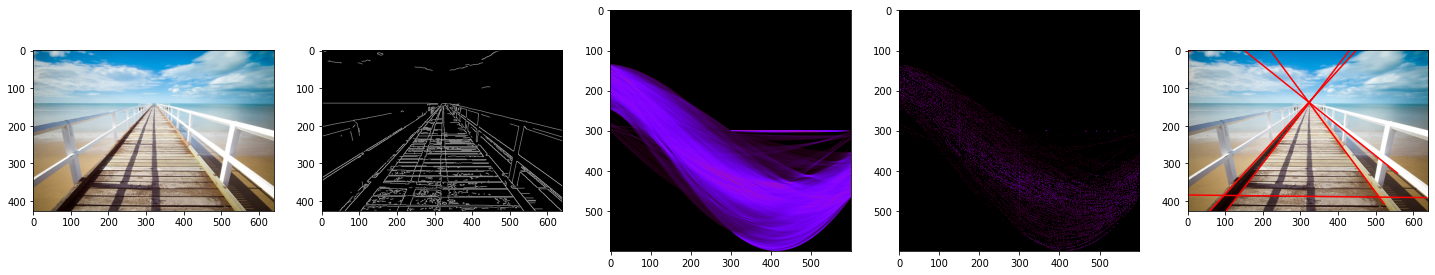

In [191]:
find_and_draw_lines_weighted(pier)

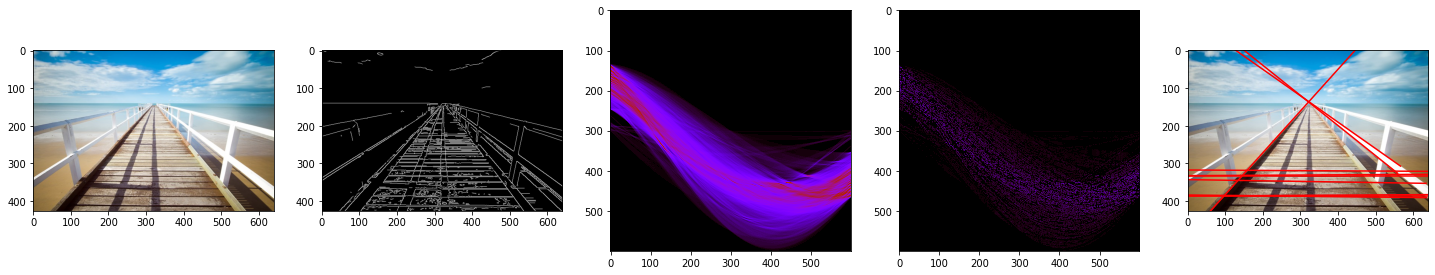

In [194]:
find_and_draw_lines(pier)